In [1]:
import pandas as pd
import networkx as nx
import warnings
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
pd.options.mode.chained_assignment = None

In [2]:
green = "#5ec962"
blue_gray = "#3b528b"
purple = "#440154"
colours = [green, purple]

In [3]:
df = pd.read_excel("data/sociogram_corrected.xlsx").dropna()
df["classroom"] = df["classroom"].astype(int)
periods = pd.read_excel("data/classroom_ids.xlsx").rename(columns = {"classroom_session_id":"classroom"})[["classroom", "period"]]
tt = periods.merge(df)
tt["classroom"] = tt["classroom"].astype("int")
tt["course"] = tt["period"] - 4

tt["question"] = tt["question"].astype('category').cat.rename_categories({
    "work_yes": "Working with",
    "work_no": "Not working with",
    "play_yes": "Playing with",
    "play_no": "Not playing with",
    "friend": "Friends",
})
# add 5 to course
tt["course"] = tt["course"] + 5

In [4]:
def compute_jaccard(a, b):
    a["both"] = a["source"].astype(str) + a["target"].astype(str)
    b["both"] = b["source"].astype(str) + b["target"].astype(str)

    matches = sum(a["both"].isin(b["both"]))

    return matches / (len(a) + len(b) - matches)

def compute_optimal_edit_path(a, b):
        a_net = nx.from_pandas_edgelist(a, create_using=nx.DiGraph)
        b_net = nx.from_pandas_edgelist(b, create_using=nx.DiGraph)

        return nx.graph_edit_distance(a_net, b_net)

def compute_similarities(work, play, random=False):
        similarities = dict()
        for classroom_id in work.classroom.unique():
                # Get classroom
                # print(f"doing classroom {classroom_id}")
                work_class = work.loc[work.classroom == classroom_id, :]
                play_class = play.loc[play.classroom == classroom_id, :]

                if random:
                        work_class["source"] = np.random.permutation(work_class["source"])
                        play_class["source"] = np.random.permutation(play_class["source"])

                jaccard = compute_jaccard(work_class, play_class)
                #edit_path = compute_optimal_edit_path(work_class, play_class)

                # Get course
                course = work_class.course.values[0]

                # Add correlation to cors dict with appropriate course
                try:
                    similarities.setdefault(course,[]).append({"jaccard": jaccard})
                except ValueError:
                        print("something wrong")
        return similarities

def compute_means(similarities):
        sim_means = dict()
        for per, vals in similarities.items():
                vals = np.array([a["jaccard"] for a in vals])
                vals = vals[np.isfinite(vals)]
                m = np.mean(vals)
                sd = np.std(vals)
                sim_means.setdefault(per,[]).append((m, sd / np.sqrt(len(vals)), len(vals)))
        return sim_means

def structure_means(sim_means, coef=1.96, type="se"):

        temp = pd.DataFrame.from_dict(sim_means).transpose()
        correlation_means = pd.DataFrame(temp[0].tolist(), index=temp.index)
        correlation_means.columns = ["m", "sd", "n"]
        if type == "se":
            c_means = correlation_means.assign(ci = lambda x: coef * x.sd / np.sqrt(x.n / 25)).sort_index()
        else:
            c_means = correlation_means.assign(ci = lambda x: coef * x.sd).sort_index()
        return c_means.index, c_means.m, c_means.ci

def compute_all(tt, dim1, dim2):
        a = tt.loc[tt.question == dim1, ["course", "classroom", "student", "value"]].drop_duplicates(
        ).dropna(subset=["value"]
        ).rename(columns = {"student":"source", "value":"target"})
        a["target"] = a["target"].astype("int")
        b = tt.loc[tt.question == dim2, ["course", "classroom", "student", "value"]].drop_duplicates(
        ).dropna(subset=["value"]
        ).rename(columns = {"student":"source", "value":"target"})
        b["target"] = b["target"].astype("int")

        # real values
        cors = compute_similarities(a, b)
        comp_cors = compute_means(cors)
        # baselines
        cors_random = compute_similarities(a, b, random=True)
        comp_cors_random = compute_means(cors_random)
        return {"Observed": comp_cors, "Null model": comp_cors_random}

In [5]:
dim1, dim2 = "work_yes", "play_yes"

In [6]:
def cor_evo_plot(cc, lims=None, plot_name="", legend=False, y_labels=True):

    fig, ax = plt.subplots()
    i = 0
    for name, a in cc.items():

        x, y, ci1 = structure_means(a, 1)
        x, y, ci2 = structure_means(a, 2)

        ax.plot(x, y, label=name, color = colours[i])
        if name == "Null model":
            ax.fill_between(x, (y - ci1), (y + ci1), color=colours[i], alpha=.3)
            ax.fill_between(x, (y - ci2), (y + ci2), color=colours[i], alpha=.1)

        i += 1

    if legend:
        plt.legend(loc=(0.03, .31), prop={'size': 18},frameon=False)

    if not y_labels:
        ax.yaxis.set_ticklabels([])

    ax.xaxis.set_ticks(np.arange(1, 11, 1))
    # ax.yaxis.set_ticks()
    plt.grid(False)

    # vertical dashed line between 6 and 7
    plt.axvline(x=6.5, color='m', linestyle='-.', linewidth = .75)

    # y axis limits
    if lims:
        plt.ylim(lims)
     
    # Hide the right and top spines
    ax.spines[['right', 'top']].set_visible(False)
    
    fig.tight_layout()

    plt.xticks(fontsize=14, color="black")
    plt.yticks(fontsize=14, color="black")

    if legend:
        fig.savefig(f"../plots/jaccard_{plot_name}.png", dpi=300)
    else:
        fig.savefig(f"../plots/jaccard_{plot_name}_no_legend.png", dpi=300)

In [7]:
def cor_evo_plot_facet(cc, ax, plot_title=""):
    i = 0
    for name, a in cc.items():
        x, y, ci1 = structure_means(a, 1)
        x, y, ci2 = structure_means(a, 2)

        if name == "Null model":
            # Plot null model line and confidence intervals
            ax.plot(x, y, label=name, color=colours[i])
            ax.fill_between(x, (y - ci1), (y + ci1), color=colours[i], alpha=.3)
            ax.fill_between(x, (y - ci2), (y + ci2), color=colours[i], alpha=.1)
        else:
            # For observed data, split into three segments
            pre_transition_idx = np.where(x == 11)[0][0]  # Index for age 11
            post_transition_idx = np.where(x == 12)[0][0]  # Index for age 12
            
            # Plot first solid segment (up to 11)
            ax.plot(x[:pre_transition_idx + 1], y[:pre_transition_idx + 1], 
                   color=colours[i], label=name)
            
            # Plot dashed transition segment (11-12)
            ax.plot(x[pre_transition_idx:post_transition_idx + 1], 
                   y[pre_transition_idx:post_transition_idx + 1], 
                   color=colours[i], linestyle='--')
            
            # Plot final solid segment (12 onwards)
            ax.plot(x[post_transition_idx:], y[post_transition_idx:], 
                   color=colours[i])
            
            # Add points and error bars
            ax.errorbar(x, y, yerr=ci1, fmt='o', 
                       color=colours[i], capsize=3, markersize=4,
                       elinewidth=1, capthick=1)

        i += 1

    ax.xaxis.set_ticks(np.arange(6, 16, 1))
    ax.set_title(plot_title, fontsize=16)
    ax.grid(False)
    
    ax.spines[['right', 'top']].set_visible(False)

    # vertical dashed line at 11.5
    ax.axvline(x=11.5, color='m', linestyle='-.', linewidth=.75)

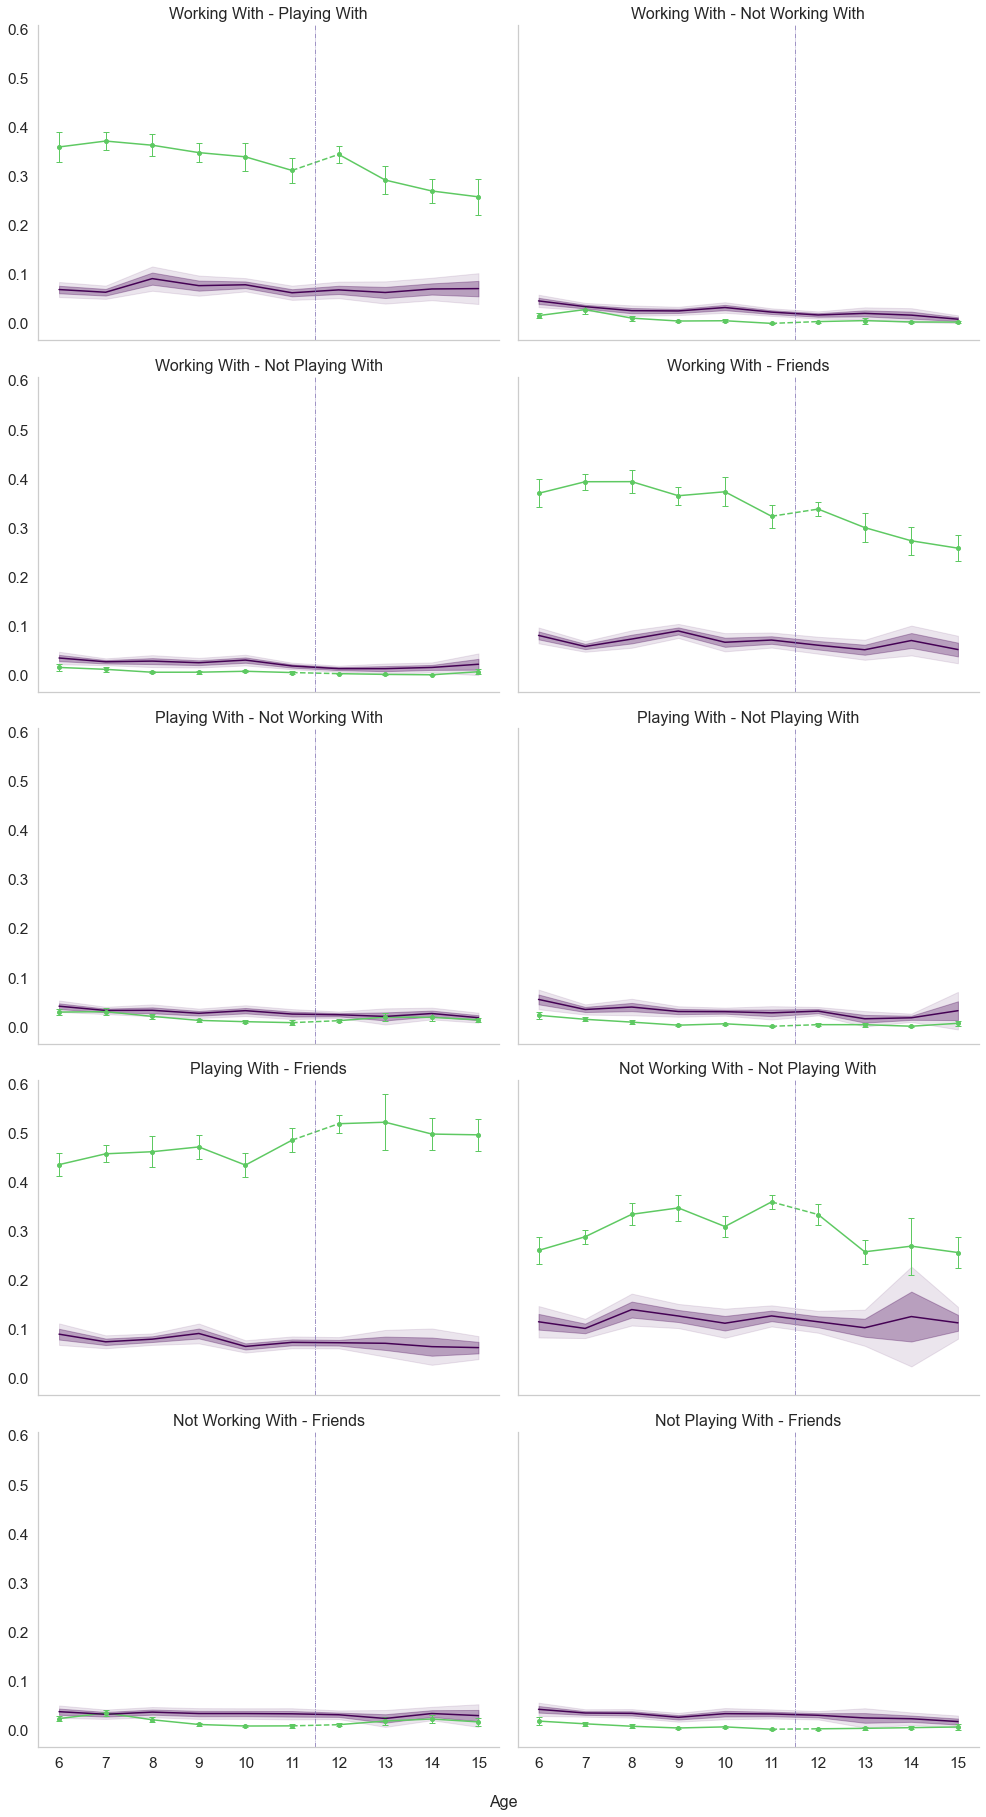

In [26]:
from itertools import combinations

# Generate all possible combinations of two different dimensions
dimension_pairs = list(combinations(["Working with", "Playing with", "Not working with", "Not playing with", "Friends"], 2))

# Number of rows needed for the subplot grid
num_rows = (len(dimension_pairs) + 1) // 2

# Create a main figure with subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(14, num_rows * 5), sharey=True, sharex=True) 
axes = axes.flatten() 

# Iterate over each pair and plot
for i, (dim1, dim2) in enumerate(dimension_pairs):
    data = compute_all(tt, dim1, dim2)
    plot_name = f"{dim1} - {dim2}".replace("_", " ").title()
    cor_evo_plot_facet(data, ax=axes[i], plot_title=plot_name)

# add x label title "Age"
fig.text(0.51, -0.01, 'Age', ha='center', fontsize=16)

# Adjust layout for better fit and save the entire figure
plt.tight_layout()
fig.savefig("plots/facet_plot_combinations.pdf", dpi=300, bbox_inches='tight')

In [22]:
def cor_evo_plot_interesting(cc, ax, lims=None, legend=False, y_labels=True):
    i = 0
    for name, a in cc.items():
        x, y, ci1 = structure_means(a, 1, type="sd")
        x, y, ci2 = structure_means(a, 2, type="sd")

        if name == "Null model":
            # Plot null model line and confidence intervals
            ax.plot(x, y, label=name, color=colours[i])
            ax.fill_between(x, (y - ci1), (y + ci1), color=colours[i], alpha=.3)
            ax.fill_between(x, (y - ci2), (y + ci2), color=colours[i], alpha=.1)
        else:
            # For observed data, split into three segments
            pre_transition_idx = np.where(x == 11)[0][0]  # Index for age 11
            post_transition_idx = np.where(x == 12)[0][0]  # Index for age 12
            
            # Plot first solid segment (up to 11)
            ax.plot(x[:pre_transition_idx + 1], y[:pre_transition_idx + 1] * 1.7, 
                   color=colours[i], label=name)
            
            # Plot dashed transition segment (11-12)
            ax.plot(x[pre_transition_idx:post_transition_idx + 1], 
                   y[pre_transition_idx:post_transition_idx + 1] * 1.7, 
                   color=colours[i], linestyle='--')
            
            # Plot final solid segment (12 onwards)
            ax.plot(x[post_transition_idx:], y[post_transition_idx:] * 1.7, 
                   color=colours[i])
            
            # Add points and error bars
            ax.errorbar(x, y * 1.7, yerr=ci1 * 1.7, fmt='o', 
                       color=colours[i], capsize=3, markersize=4,
                       elinewidth=1, capthick=1)
        i += 1

    if legend:
        ax.legend(loc=(0.03, .31), prop={'size': 18}, frameon=False, fontsize=FONT_BIG)

    if not y_labels:
        ax.yaxis.set_ticklabels([])

    ax.xaxis.set_ticks(np.arange(6, 16, 1))
    ax.grid(False)
    ax.axvline(x=11.5, color=VERTICAL_LINE_COLOUR, linestyle='-.', linewidth=.75)

    if lims:
        ax.set_ylim(lims)

    ax.spines[['right', 'top']].set_visible(False)
    ax.tick_params(axis='both', which='major')

NameError: name 'cor_evo_plot_interesting' is not defined

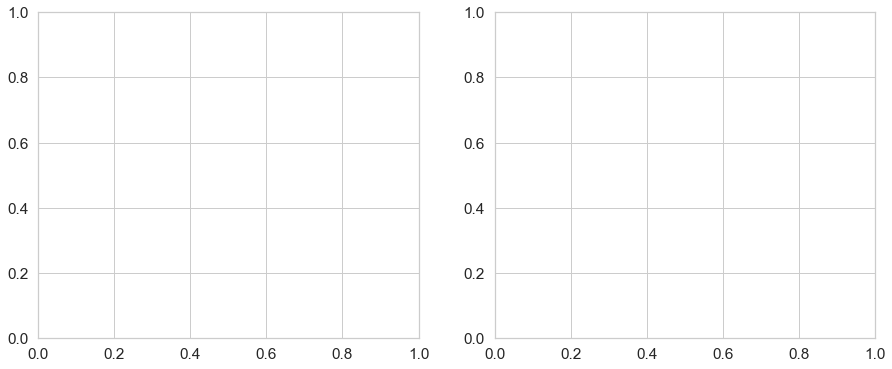

In [10]:
from plot_funcs import paint_it_black
from plot_vars import FONT_BIG
sns.set_theme(font_scale=1.4, style="whitegrid")
# Create main figure with required number of subplots (e.g., 1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  

# First plot
data_1 = compute_all(tt, "Working with", "Playing with")
cor_evo_plot_interesting(data_1, axes[0], lims=[0, .7])
axes[0].set_title('"Working with" and "Playing with"', fontsize=FONT_BIG)

axes[0].text(0.1, 0.8, "a", 
             transform=axes[0].transAxes, 
             fontweight='bold', 
             va='top', 
             ha='right', 
             fontsize=FONT_BIG)

axes[0].tick_params(axis='x', which='both', bottom=True, labelbottom=True, labelsize=FONT_BIG)
axes[0].tick_params(axis='y', which='both', left=True, labelleft=True, labelsize=FONT_BIG)

# Second plot
data_2 = compute_all(tt, "Not working with", "Not playing with")
cor_evo_plot_interesting(data_2, axes[1], lims=[0, .7], legend=True, y_labels=False)
axes[1].set_title('"Not Working with" and "Not Playing with"', fontsize=FONT_BIG)
axes[1].text(0.1, 0.8, "b", 
             transform=axes[1].transAxes, 
             fontweight='bold', 
             va='top', 
             ha='right', 
             fontsize=FONT_BIG)

axes[1].tick_params(axis='x', which='both', bottom=True, labelbottom=True, labelsize=FONT_BIG)

paint_it_black(axes)

fig.text(0.51, 0.03, "Age", ha='center', va='center', fontsize=FONT_BIG)
fig.text(-0.01, 0.5, 'Sociogram overlap', ha='center', va='center', rotation='vertical', fontsize=FONT_BIG)
fig.tight_layout(rect=[0, 0.04, 1, 1])

# Optionally save the figure
fig.savefig("plots/figure_3_interesting_correlations.pdf", dpi=300, bbox_inches='tight')


In [11]:
data_1 = compute_all(tt, "Working with", "Playing with")

In [1]:
tt

NameError: name 'tt' is not defined

In [14]:
df = pd.DataFrame([
    {'course': k, 'mean': v[0][0], 'sd': v[0][1], 'n': v[0][2]}
    for k, v in data_1["Observed"].items()
])

# Sort by course number (optional)
df = df.sort_values('course').reset_index(drop=True)

In [15]:
df

,course,mean,sd,n
0,1,0.359759,0.025899,18
1,2,0.371786,0.018314,26
2,3,0.363281,0.019213,19
3,4,0.348234,0.016803,20
4,5,0.339629,0.026213,21
5,6,0.311947,0.021255,17
6,7,0.344605,0.017391,25
7,8,0.292318,0.018061,10
8,9,0.270079,0.017490,13
9,10,0.258139,0.026348,13


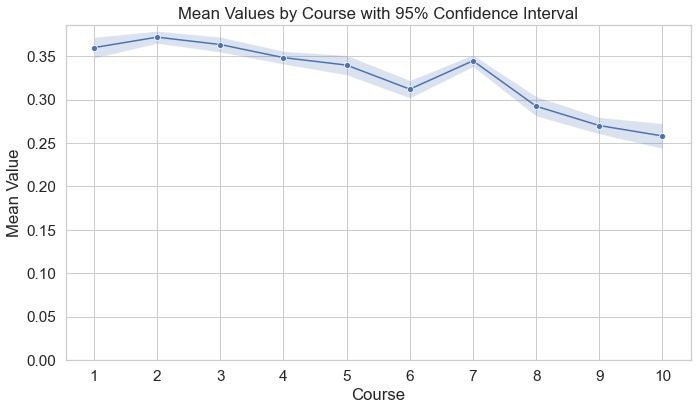

In [16]:
df['se'] = df['sd'] / np.sqrt(df['n'])
df['margin_error'] = 1.96 * df['se']

# Create the plot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create line plot with confidence interval
sns.lineplot(data=df, x='course', y='mean', marker='o')

# Add shaded confidence interval
plt.fill_between(df['course'],
                 df['mean'] - df['margin_error'],
                 df['mean'] + df['margin_error'],
                 alpha=0.2)  # alpha controls transparency

# Customize the plot
plt.title('Mean Values by Course with 95% Confidence Interval')
plt.xlabel('Course')
plt.ylabel('Mean Value')

# Optional: Set x-axis to show all course numbers
plt.xticks(df['course'])

# Optional: Adjust y-axis to start from 0
plt.ylim(bottom=0)

# Show the plot
plt.tight_layout()
plt.show()


Answer:


Statistical Analysis Summary:
   course  t_statistic  p_value  effect_size_hl  percent_increase
0       6       46.972    0.000          15.661           425.811
1       7       74.737    0.000          20.731           369.102
2       8       61.347    0.000          19.905           376.008
3       9       68.502    0.000          21.664           369.855
4      10       43.094    0.000          13.301           331.799
5      11       44.982    0.000          15.431           351.382
6      12       68.725    0.000          19.441           351.889
7      13       39.741    0.000          17.773           469.920
8      14       24.518    0.000           9.619           242.350
9      15       20.865    0.000           8.187           277.351

Average Hodges-Lehmann effect size: 16.17
Average percentage increase over null model: 356.5%


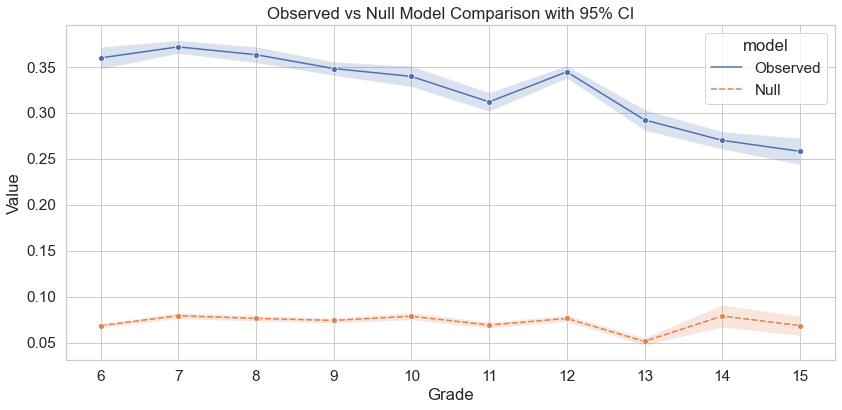

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Create DataFrames (same as before)
def create_df(data, model_type):
    df = pd.DataFrame([
        {'course': k, 'mean': v[0][0], 'sd': v[0][1], 'n': v[0][2]}
        for k, v in data.items()
    ])
    df['model'] = model_type
    df['se'] = df['sd'] / np.sqrt(df['n'])
    df['margin_error'] = 1.96 * df['se']
    return df.sort_values('course').reset_index(drop=True)

df_observed = create_df(data_1["Observed"], "Observed")
df_null = create_df(data_1["Null model"], "Null")

# Helper function to compute Hodges-Lehmann effect size
def hodges_lehmann_effect_size(mean1, sd1, n1, mean2, sd2, n2, num_samples=10000):
    # Generate samples based on normal distribution parameters
    np.random.seed(42)  # for reproducibility
    sample1 = np.random.normal(mean1, sd1, size=(num_samples, n1))
    sample2 = np.random.normal(mean2, sd2, size=(num_samples, n2))
    
    # Calculate all pairwise differences for each simulation
    differences = []
    for s1, s2 in zip(sample1, sample2):
        diff_matrix = s1[:, None] - s2
        differences.extend(diff_matrix.flatten())
    
    # Calculate Hodges-Lehmann estimator (median of all pairwise differences)
    hl_estimator = np.median(differences)
    
    # Scale by pooled standard deviation for standardized effect size
    pooled_sd = np.sqrt((sd1**2 + sd2**2) / 2)
    standardized_hl = hl_estimator / pooled_sd
    
    return standardized_hl

# Calculate Hodges-Lehmann effect sizes and percentage differences
t_test_results = []
for course in df_observed['course'].unique():
    obs = df_observed[df_observed['course'] == course].iloc[0]
    null = df_null[df_null['course'] == course].iloc[0]
    
    # Calculate Hodges-Lehmann effect size
    hl_effect = hodges_lehmann_effect_size(
        obs['mean'], obs['sd'], obs['n'],
        null['mean'], null['sd'], null['n']
    )
    
    # Calculate percentage difference (same as before)
    percent_increase = (obs['mean'] - null['mean']) / null['mean'] * 100
    
    # Calculate t-statistic and p-value (same as before)
    t_stat = (obs['mean'] - null['mean']) / np.sqrt(obs['se']**2 + null['se']**2)
    df = obs['n'] + null['n'] - 2
    p_val = 2 * (1 - stats.t.cdf(abs(t_stat), df))
    
    t_test_results.append({
        'course': course,
        't_statistic': t_stat,
        'p_value': p_val,
        'effect_size_hl': hl_effect,
        'percent_increase': percent_increase
    })

df_stats = pd.DataFrame(t_test_results)

# Create visualization (same as before)
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

df_combined = pd.concat([df_observed, df_null])

sns.lineplot(data=df_combined, x='course', y='mean', hue='model', marker='o', style='model')

for model in ['Observed', 'Null']:
    df_temp = df_combined[df_combined['model'] == model]
    plt.fill_between(df_temp['course'],
                     df_temp['mean'] - df_temp['margin_error'],
                     df_temp['mean'] + df_temp['margin_error'],
                     alpha=0.2)

plt.title('Observed vs Null Model Comparison with 95% CI')
plt.xlabel('Grade')
plt.ylabel('Value')
plt.xticks(df_observed['course'])

# Format and display statistical results
pd.set_option('display.float_format', lambda x: '%.3f' % x)
statistical_summary = df_stats.sort_values('course')
print("\nStatistical Analysis Summary:")
print(statistical_summary)

# Calculate average effect size and range
mean_effect = df_stats['effect_size_hl'].mean()
mean_percent = df_stats['percent_increase'].mean()
print(f"\nAverage Hodges-Lehmann effect size: {mean_effect:.2f}")
print(f"Average percentage increase over null model: {mean_percent:.1f}%")

plt.tight_layout()
plt.show()


Most significant grade-to-grade changes:
   grade_pair  grade_difference  percent_change  p_value  hl_effect
15     7 → 14                 7         -27.356    0.000      5.679
22     8 → 14                 6         -25.656    0.000      5.077
28     9 → 14                 5         -22.443    0.000      4.560
7      6 → 14                 8         -24.928    0.000      4.065
40    12 → 14                 2         -21.626    0.000      4.274
16     7 → 15                 8         -30.568    0.000      5.008
8      6 → 15                 9         -28.247    0.000      3.896
23     8 → 15                 7         -28.943    0.000      4.564
12     7 → 11                 4         -16.095    0.000      3.017
33    10 → 14                 4         -20.478    0.000      3.123
29     9 → 15                 6         -25.872    0.000      4.081
14     7 → 13                 6         -21.375    0.000      4.371
34    10 → 15                 5         -23.994    0.000      3.103
41    

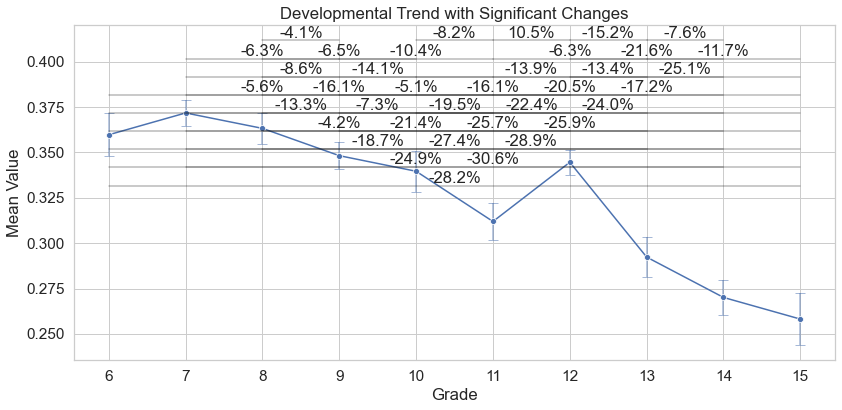

In [16]:
import pandas as pd
import numpy as np
from scipy import stats
from itertools import combinations


def hodges_lehmann_effect_size(mean1, sd1, n1, mean2, sd2, n2, num_samples=10000):
    np.random.seed(42)
    # Convert n1 and n2 to integers
    n1_int = int(n1)
    n2_int = int(n2)
    
    sample1 = np.random.normal(mean1, sd1, size=(num_samples, n1_int))
    sample2 = np.random.normal(mean2, sd2, size=(num_samples, n2_int))
    
    differences = []
    for s1, s2 in zip(sample1, sample2):
        diff_matrix = s1[:, None] - s2
        differences.extend(diff_matrix.flatten())
    
    hl_estimator = np.median(differences)
    pooled_sd = np.sqrt((sd1**2 + sd2**2) / 2)
    return hl_estimator / pooled_sd

df = pd.DataFrame([
    {'course': k, 'mean': v[0][0], 'sd': v[0][1], 'n': v[0][2]}
    for k, v in data_1["Observed"].items()
]).sort_values('course').reset_index(drop=True)

# Calculate all pairwise comparisons
pairs = list(combinations(df['course'], 2))
comparisons = []

for course1, course2 in pairs:
    data1 = df[df['course'] == course1].iloc[0]
    data2 = df[df['course'] == course2].iloc[0]

    # Calculate percentage change
    percent_change = ((data2['mean'] - data1['mean']) / data1['mean']) * 100

    # Calculate t-test
    # Using Welch's t-test (unequal variances)
    se1 = data1['sd'] / np.sqrt(data1['n'])
    se2 = data2['sd'] / np.sqrt(data2['n'])
    t_stat = (data2['mean'] - data1['mean']) / np.sqrt(se1**2 + se2**2)

    # Welch–Satterthwaite equation for degrees of freedom
    df_welch = ((se1**2 + se2**2)**2) / ((se1**4/(data1['n']-1)) + (se2**4/(data2['n']-1)))
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df_welch))

    # Calculate Cohen's d effect size
    pooled_sd = np.sqrt((data1['sd']**2 + data2['sd']**2) / 2)
    hl_effect = hodges_lehmann_effect_size(
        data1['mean'], data1['sd'], data1['n'],
        data2['mean'], data2['sd'], data2['n']
    )

    comparisons.append({
        'grade_pair': f'{course1} → {course2}',
        'grade_difference': course2 - course1,
        'percent_change': percent_change,
        'absolute_difference': data2['mean'] - data1['mean'],
        't_statistic': t_stat,
        'p_value': p_value,
        'hl_effect': hl_effect  
    })

# Create DataFrame of comparisons
df_comparisons = pd.DataFrame(comparisons)

# Sort by absolute p-value to see most significant changes
df_comparisons_sorted = df_comparisons.sort_values('p_value')

# Print results with better formatting
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
print("\nMost significant grade-to-grade changes:")
print(df_comparisons_sorted[['grade_pair', 'grade_difference', 'percent_change', 'p_value', 'hl_effect']].to_string())

# Let's also visualize the significant changes
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Plot the trend line
sns.lineplot(data=df, x='course', y='mean', marker='o')

# Add error bars
plt.errorbar(df['course'], df['mean'],
             yerr=1.96 * df['sd']/np.sqrt(df['n']),
             fmt='none', capsize=5, alpha=0.5)

# Highlight significant changes (p < 0.05)
significant_pairs = df_comparisons[df_comparisons['p_value'] < 0.05]
max_y = df['mean'].max() + 0.05
for _, row in significant_pairs.iterrows():
    grades = row['grade_pair'].split(' → ')
    g1, g2 = int(grades[0]), int(grades[1])
    y = max_y - 0.01 * (abs(g2-g1))  # Stagger the bars vertically
    plt.plot([g1, g2], [y, y], 'k-', alpha=0.3)
    plt.text((g1 + g2)/2, y, f'{row["percent_change"]:.1f}%',
             ha='center', va='bottom')

plt.title('Developmental Trend with Significant Changes')
plt.xlabel('Grade')
plt.ylabel('Mean Value')
plt.xticks(df['course'])

plt.tight_layout()
plt.show()

# Per gender

In [14]:
gender = pd.read_excel("../data/genders.xlsx")

In [15]:
# remove all genders that are not "Nen" or "Nena" and rename them to "Boy" and "Girl"
gender = gender[gender['genere'].isin(['Nen', 'Nena'])]
gender['genere'] = gender['genere'].replace({'Nen': 'Boy', 'Nena': 'Girl'})
# select only student and genere
gender = gender[['student', 'genere']]

In [17]:
gg = tt.merge(gender)

In [ ]:
girls = gg[gg['genere'] == 'Girl']
data_girls = compute_all(girls, "Working with", "Playing with")


Most significant grade-to-grade changes:
   grade_pair  grade_difference  percent_change  p_value  cohens_d
22      3 → 9                 6         -35.680    0.000    -5.778
40      7 → 9                 2         -31.377    0.000    -4.976
15      2 → 9                 7         -27.351    0.000    -4.061
33      5 → 9                 4         -30.304    0.000    -3.572
28      4 → 9                 5         -27.899    0.000    -4.572
23     3 → 10                 7         -27.908    0.000    -3.769
7       1 → 9                 8         -27.776    0.000    -3.131
19      3 → 6                 3         -19.632    0.000    -2.782
42      8 → 9                 1         -33.105    0.000    -4.921
41     7 → 10                 3         -23.086    0.000    -3.011
43     8 → 10                 2         -25.022    0.000    -3.144
37      6 → 9                 3         -19.968    0.000    -2.403
34     5 → 10                 5         -21.883    0.000    -2.286
9       2 → 3       

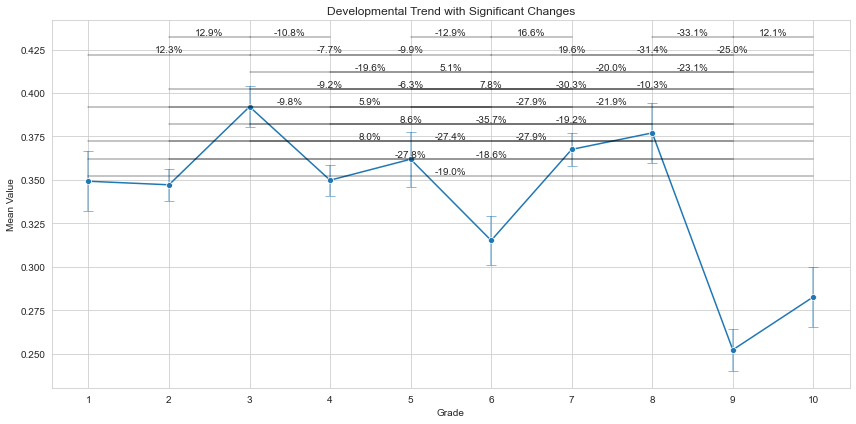

In [23]:
import pandas as pd
import numpy as np
from scipy import stats
from itertools import combinations

df = pd.DataFrame([
    {'course': k, 'mean': v[0][0], 'sd': v[0][1], 'n': v[0][2]}
    for k, v in data_girls["Observed"].items()
]).sort_values('course').reset_index(drop=True)

# Calculate all pairwise comparisons
pairs = list(combinations(df['course'], 2))
comparisons = []

for course1, course2 in pairs:
    data1 = df[df['course'] == course1].iloc[0]
    data2 = df[df['course'] == course2].iloc[0]

    # Calculate percentage change
    percent_change = ((data2['mean'] - data1['mean']) / data1['mean']) * 100

    # Calculate t-test
    # Using Welch's t-test (unequal variances)
    se1 = data1['sd'] / np.sqrt(data1['n'])
    se2 = data2['sd'] / np.sqrt(data2['n'])
    t_stat = (data2['mean'] - data1['mean']) / np.sqrt(se1**2 + se2**2)

    # Welch–Satterthwaite equation for degrees of freedom
    df_welch = ((se1**2 + se2**2)**2) / ((se1**4/(data1['n']-1)) + (se2**4/(data2['n']-1)))
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df_welch))

    # Calculate Cohen's d effect size
    pooled_sd = np.sqrt((data1['sd']**2 + data2['sd']**2) / 2)
    cohens_d = (data2['mean'] - data1['mean']) / pooled_sd

    comparisons.append({
        'grade_pair': f'{course1} → {course2}',
        'grade_difference': course2 - course1,
        'percent_change': percent_change,
        'absolute_difference': data2['mean'] - data1['mean'],
        't_statistic': t_stat,
        'p_value': p_value,
        'cohens_d': cohens_d
    })

# Create DataFrame of comparisons
df_comparisons = pd.DataFrame(comparisons)

# Sort by absolute p-value to see most significant changes
df_comparisons_sorted = df_comparisons.sort_values('p_value')

# Print results with better formatting
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
print("\nMost significant grade-to-grade changes:")
print(df_comparisons_sorted[['grade_pair', 'grade_difference', 'percent_change', 'p_value', 'cohens_d']].to_string())

# Let's also visualize the significant changes
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Plot the trend line
sns.lineplot(data=df, x='course', y='mean', marker='o')

# Add error bars
plt.errorbar(df['course'], df['mean'],
             yerr=1.96 * df['sd']/np.sqrt(df['n']),
             fmt='none', capsize=5, alpha=0.5)

# Highlight significant changes (p < 0.05)
significant_pairs = df_comparisons[df_comparisons['p_value'] < 0.05]
max_y = df['mean'].max() + 0.05
for _, row in significant_pairs.iterrows():
    grades = row['grade_pair'].split(' → ')
    g1, g2 = int(grades[0]), int(grades[1])
    y = max_y - 0.01 * (abs(g2-g1))  # Stagger the bars vertically
    plt.plot([g1, g2], [y, y], 'k-', alpha=0.3)
    plt.text((g1 + g2)/2, y, f'{row["percent_change"]:.1f}%',
             ha='center', va='bottom')

plt.title('Developmental Trend with Significant Changes')
plt.xlabel('Grade')
plt.ylabel('Mean Value')
plt.xticks(df['course'])

plt.tight_layout()
plt.show()

In [24]:
boys = gg[gg['genere'] == 'Boy']
data_boys = compute_all(boys, "Working with", "Playing with")


Most significant grade-to-grade changes:
   grade_pair  grade_difference  percent_change  p_value  cohens_d
22      3 → 9                 6         -35.680    0.000    -5.778
40      7 → 9                 2         -31.377    0.000    -4.976
15      2 → 9                 7         -27.351    0.000    -4.061
33      5 → 9                 4         -30.304    0.000    -3.572
28      4 → 9                 5         -27.899    0.000    -4.572
23     3 → 10                 7         -27.908    0.000    -3.769
7       1 → 9                 8         -27.776    0.000    -3.131
19      3 → 6                 3         -19.632    0.000    -2.782
42      8 → 9                 1         -33.105    0.000    -4.921
41     7 → 10                 3         -23.086    0.000    -3.011
43     8 → 10                 2         -25.022    0.000    -3.144
37      6 → 9                 3         -19.968    0.000    -2.403
34     5 → 10                 5         -21.883    0.000    -2.286
9       2 → 3       

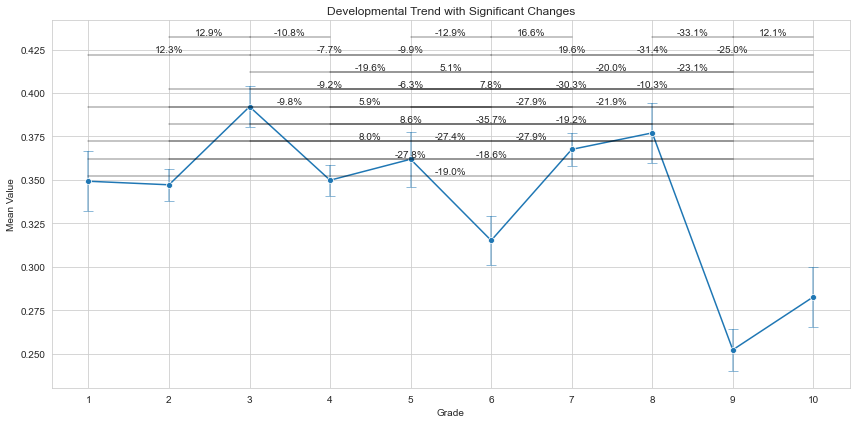

In [25]:
import pandas as pd
import numpy as np
from scipy import stats
from itertools import combinations

df = pd.DataFrame([
    {'course': k, 'mean': v[0][0], 'sd': v[0][1], 'n': v[0][2]}
    for k, v in data_girls["Observed"].items()
]).sort_values('course').reset_index(drop=True)

# Calculate all pairwise comparisons
pairs = list(combinations(df['course'], 2))
comparisons = []

for course1, course2 in pairs:
    data1 = df[df['course'] == course1].iloc[0]
    data2 = df[df['course'] == course2].iloc[0]

    # Calculate percentage change
    percent_change = ((data2['mean'] - data1['mean']) / data1['mean']) * 100

    # Calculate t-test
    # Using Welch's t-test (unequal variances)
    se1 = data1['sd'] / np.sqrt(data1['n'])
    se2 = data2['sd'] / np.sqrt(data2['n'])
    t_stat = (data2['mean'] - data1['mean']) / np.sqrt(se1**2 + se2**2)

    # Welch–Satterthwaite equation for degrees of freedom
    df_welch = ((se1**2 + se2**2)**2) / ((se1**4/(data1['n']-1)) + (se2**4/(data2['n']-1)))
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df_welch))

    # Calculate Cohen's d effect size
    pooled_sd = np.sqrt((data1['sd']**2 + data2['sd']**2) / 2)
    cohens_d = (data2['mean'] - data1['mean']) / pooled_sd

    comparisons.append({
        'grade_pair': f'{course1} → {course2}',
        'grade_difference': course2 - course1,
        'percent_change': percent_change,
        'absolute_difference': data2['mean'] - data1['mean'],
        't_statistic': t_stat,
        'p_value': p_value,
        'cohens_d': cohens_d
    })

# Create DataFrame of comparisons
df_comparisons = pd.DataFrame(comparisons)

# Sort by absolute p-value to see most significant changes
df_comparisons_sorted = df_comparisons.sort_values('p_value')

# Print results with better formatting
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
print("\nMost significant grade-to-grade changes:")
print(df_comparisons_sorted[['grade_pair', 'grade_difference', 'percent_change', 'p_value', 'cohens_d']].to_string())

# Let's also visualize the significant changes
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Plot the trend line
sns.lineplot(data=df, x='course', y='mean', marker='o')

# Add error bars
plt.errorbar(df['course'], df['mean'],
             yerr=1.96 * df['sd']/np.sqrt(df['n']),
             fmt='none', capsize=5, alpha=0.5)

# Highlight significant changes (p < 0.05)
significant_pairs = df_comparisons[df_comparisons['p_value'] < 0.05]
max_y = df['mean'].max() + 0.05
for _, row in significant_pairs.iterrows():
    grades = row['grade_pair'].split(' → ')
    g1, g2 = int(grades[0]), int(grades[1])
    y = max_y - 0.01 * (abs(g2-g1))  # Stagger the bars vertically
    plt.plot([g1, g2], [y, y], 'k-', alpha=0.3)
    plt.text((g1 + g2)/2, y, f'{row["percent_change"]:.1f}%',
             ha='center', va='bottom')

plt.title('Developmental Trend with Significant Changes')
plt.xlabel('Grade')
plt.ylabel('Mean Value')
plt.xticks(df['course'])

plt.tight_layout()
plt.show()